# Quiz/Hands-on: Analyzing airline tweets using NLP

## Imports

In [249]:
import pandas as pd
import re

from matplotlib import pyplot as plt
from datetime import datetime

## Load Data

In [95]:
df = pd.read_csv("../resources/airline_tweets.csv")
df

,tweet_id,airline,handle,text,tweet_created,user_timezone
0,570306133677760000,Virgin America,cairdin,@VirginAmerica What @dhepburn said.,2/24/15 11:35,Eastern Time (US & Canada)
1,570301130888122000,Virgin America,jnardino,@VirginAmerica plus you've added commercials t...,2/24/15 11:15,Pacific Time (US & Canada)
2,570301083672813000,Virgin America,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,2/24/15 11:15,Central Time (US & Canada)
3,570301031407624000,Virgin America,jnardino,@VirginAmerica it's really aggressive to blast...,2/24/15 11:15,Pacific Time (US & Canada)
4,570300817074462000,Virgin America,jnardino,@VirginAmerica and it's a really big bad thing...,2/24/15 11:14,Pacific Time (US & Canada)
...,...,...,...,...,...,...
14635,569587686496825000,American,KristenReenders,@AmericanAir thank you we got on a different f...,2/22/15 12:01,NaN
14636,569587371693355000,American,itsropes,@AmericanAir leaving over 20 minutes Late Flig...,2/22/15 11:59,NaN
14637,569587242672398000,American,sanyabun,@AmericanAir Please bring American Airlines to...,2/22/15 11:59,NaN
14638,569587188687634000,American,SraJackson,"@AmericanAir you have my money, you change my ...",2/22/15 11:59,Eastern Time (US & Canada)


# Data Exploration

## Finding Airlines

For this activity, I am given a dataset to work with. However, I do not anything about it or about how it was collected. 

The data seems to be tweets which are directed towards different airlines. I do not know which specific airlines these are. I will try to find this out in the next section by finding the most mentioned twitter handles.

In [175]:
# Get twitter handles and the number of mentions
twitter_handles_freq = {}
tw_handle_regex = re.compile("@[\w]+")

for value in df['text']:
    for h in tw_handle_regex.findall(value):
        h = h.lower()
        twitter_handles_freq[h] = twitter_handles_freq.get(h, 0) + 1
        
# Remove handles mentioned < 10 times
twitter_handles_freq = {k:v for k, v in twitter_handles_freq.items() if v >= 10}
twitter_handles_freq

{'@virginamerica': 519,
 '@ladygaga': 12,
 '@carrieunderwood': 12,
 '@southwestair': 2458,
 '@jetblue': 2248,
 '@united': 3894,
 '@americanair': 2961,
 '@delta': 68,
 '@usairways': 3000,
 '@phlairport': 20,
 '@imaginedragons': 45,
 '@fortunemagazine': 12,
 '@love_dragonss': 10,
 '@wsj': 13,
 '@dfwairport': 17}

Aside from airports, the tweets also have mentions of artists such as Lady Gaga and Carrie Underwood. We remove these to get only the airline names.

In [177]:
# Remove non-airlines
non_airport = ['@ladygaga', '@carrieunderwood', '@imaginedragons', '@fortunemagazine', '@love_dragonss', '@wsj']
for n in non_airport:
    try:
        twitter_handles_freq.pop(n)
    except Exception:
        pass
twitter_handles_freq

{'@virginamerica': 519,
 '@southwestair': 2458,
 '@jetblue': 2248,
 '@united': 3894,
 '@americanair': 2961,
 '@delta': 68,
 '@usairways': 3000,
 '@phlairport': 20,
 '@dfwairport': 17}

We then create a frequency graph to see the distribution of airline tweets in the corpus. 

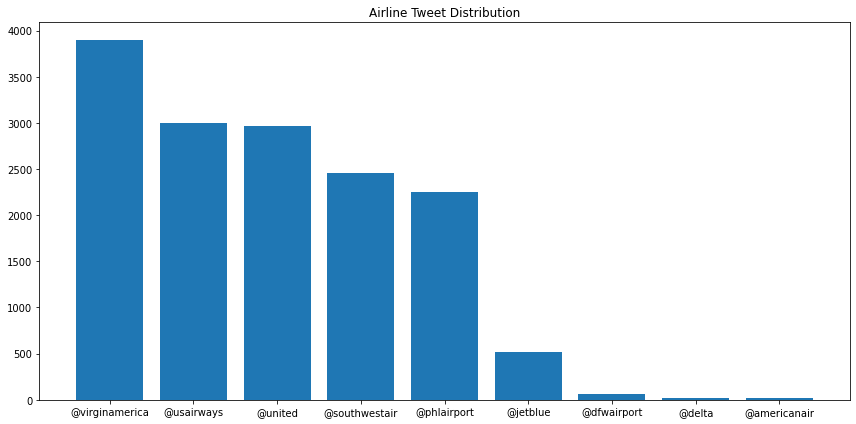

In [212]:
fig, ax = plt.subplots(figsize=(12,6))
x = sorted(twitter_handles_freq.keys(), reverse=True)
y = sorted(twitter_handles_freq.values(), reverse=True)
ax.bar(x, y)
ax.set_title("Airline Tweet Distribution")
plt.tight_layout()

It seems that there are 6 main airlines featured in the dataset (from Virgin America to JetBlue).

References to other airlines may be due to people comparing services between airlines, as seen below with tweets referring to *@delta*.

In [252]:
for t in df[df['text'].apply(lambda x: "@delta" in x)]['text']:
    print(t)

@united considering it. Currently gold on @delta. Why should I make the jump for an upcoming flight from SFO to Singapore?
@united @delta lost my luggage from ATL to  hdn luggage in denver and said @united will deliver my luggage to HDN airport claim# hdndl11785
@SouthwestAir, you're really going to let @delta and @virginamerica get the best of you? http://t.co/vUdWJm1lYB
@SouthwestAir why am I still in Baltimore?! @delta is doing laps around us and laughing about it. # ridiculous
@JetBlue that's where we all get on the same page. Cancelled Flighted it 45 mins ago. @delta @SouthwestAir help flights from @tfgreenairport to MCO?
@usairways Cancelled Flighted and rescheduled. said I'd have to pay $75 for earlier flight at next gate. Today @delta proactively offered same for $0
@USAirways 4+ hour hold, finally Cancelled Flighted ticket! sticking to @delta @Expedia who allow easy online Cancelled Flights/refunds! http://t.co/RKVCZBpdCE
@USAirways holding 30+ min and listening to your shitty

# Date Distribution

In [269]:
# Convert string to datetime object
df['tweet_created'] = df['tweet_created'].map(lambda d: datetime.strptime(d, "%m/%d/%y %H:%M"))

In [285]:
df['tweet_created'](by=[df["tweet_created"].dt.month, df["tweet_created"].dt.day]).count()

TypeError: 'Series' object is not callable

## Text Cleaning

Remove special characters, leading and trailing whitespaces, Twitter handles, hashtags, etc.

In [86]:
t = "Hello, world!"
re.sub("[^\w?!\.,\s]+", "", t)
re.sub("[^A-Za-z0-9]+", "", text)

'Hello, world!'

In [90]:
def clean(text: str) -> str:
    """Clean text."""
    
    # Remove:
    
    # Twitter handles and hashtags
    text = re.sub("[#@][\w]+", "", text)
    
    # Special characters (except sentence endings)
    text = re.sub("[^\w?!\.,\s]+", "", text)
    
    # Extra spaces
    text = re.sub("\s+", " ", text)  # Multiple consecutive spaces
    text = re.sub("\s\.", ".", text)  # Space before period
    text = text.strip()  # Leading and trailing whitespaces
    
    
    return text

In [91]:
df['text'].map(clean)

0                                               What said.
1        plus youve added commercials to the experience...
2        I didnt today... Must mean I need to take anot...
3        its really aggressive to blast obnoxious enter...
4                  and its a really big bad thing about it
                               ...                        
14635    thank you we got on a different flight to Chic...
14636    leaving over 20 minutes Late Flight. No warnin...
14637                    Please bring American Airlines to
14638    you have my money, you change my flight, and d...
14639    we have 8 ppl so we need 2 know how many seats...
Name: text, Length: 14640, dtype: object

In [70]:
pd.concat([df['text'], ], axis=1)